In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob
import pickle
import ipywidgets as widgets

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
def calibrate_camera():    
    color_channels = 3 #Red, Green, Blue
    #Prepare object points
    #The number of inside corners in x
    nx = 9
    #The number of inside corners in y
    ny = 6
    objp = np.zeros((nx*ny, color_channels), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, color_channels - 1)
    
    objpoints = []
    imgpoints = []
    
    #wildcard: matching all expressions.
    images = glob.glob('camera_cal/calibration*.jpg')
    
    for idx, imname in enumerate(images):
        #
        img = cv2.imread(imname)
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        #Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
        if ret == True:
            
            objpoints.append(objp)
            
            imgpoints.append(corners)
            
    #Do camera calibration given object points and image points
    return objpoints, imgpoints

objpoints, imgpoints = calibrate_camera()

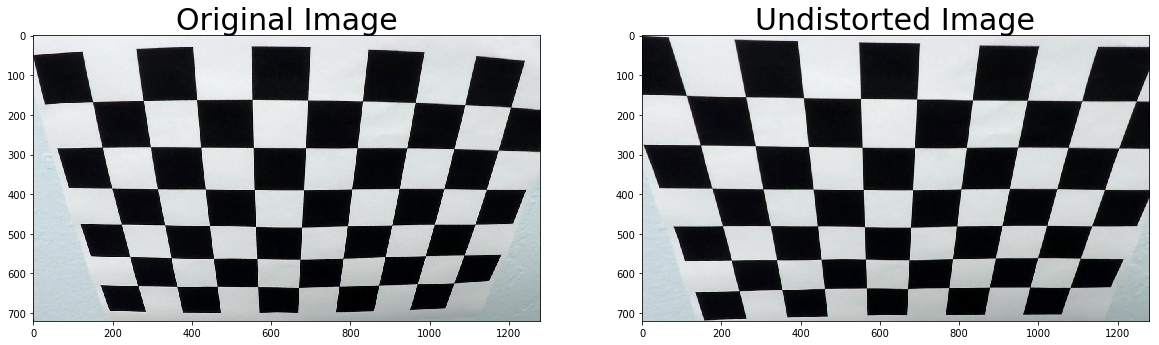

In [3]:
#Check on a random image
test_img = cv2.imread('camera_cal/calibration2.jpg')
test_img_size = (test_img.shape[1], test_img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, test_img_size, None, None)

dst = cv2.undistort(test_img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [5]:
import advancedCV as aCV
from enum import Enum

class LineStatus(Enum):
    NORMAL = 0
    RESET = 1
    NOT_ENOUGH_DATA = 2
    FLUCTUATING = 3
    
# Define a class to receive the characteristics of each line detection
class Line(object):
    
    FILTER_LENGTH = 5
    DIFF_LIMIT = np.array([0.01, 1.0, 300.])
    TRUST_LIMIT = 1000
    TAIL_LIMIT = 100
    RESET_LIMIT = 5
        
    #Observation: the point of the lane nearest to the car does not change much
    
    def __init__(self):
        self.reset()
        
        
    def reset(self):
        self.count = 0
        self.status = LineStatus.RESET
        #was the line detected in the last iteration?
        self.detected = False  
        
        #x values of the last n fits of the line
        self.recent_xfitted = [] 
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #polynomial coefficients for the most recent fit
        self.recent_coeffs = []  
        
        #radius of curvature of the line in some units
        self.curvature_in_meter = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
#         #x values for detected line pixels
#         self.allx = None  
#         #y values for detected line pixels
#         self.ally = None
    
        #lane position
        self.xpos = None
        self.warning = ""
    
    
    def measure_curvature_real_by_data(self, ploty, xm_per_pix = 3.7/700, ym_per_pix = 30/720):
        '''
        Calculates the curvature of polynomial functions in meters.
        '''
   
        # Make sure to feed in your real data instead in your project!
        real_coeff = np.polyfit(ploty * ym_per_pix, self.bestx * xm_per_pix, 2) 
        #Ax^2 + Bx + C
        A, B, C = real_coeff[0], real_coeff[1], real_coeff[2]

        # Define y-value where we want radius of curvature
        # We'll choose the maximum y-value, corresponding to the bottom of the image
        
        y_eval = np.max(ploty)

        y_real = y_eval * ym_per_pix

        ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
        self.curvature_in_meter = (1+(2*A*y_real + B) ** 2) ** (1.5) / abs(2*A)  ## Implement the calculation of the left line here

        return self.curvature_in_meter
    
    def sanity_check(self, new_coeff, x, ploty):
        
        if self.best_fit == None:
            self.warning = "no built-in fit. Update anyway"
            self.status = LineStatus.NORMAL
            return True
            
        if new_coeff == None or new_coeff == []:
            self.warning = "no new coeff"
            self.status = LineStatus.NOT_ENOUGH_DATA
            return False
            
        if len(x) < self.TRUST_LIMIT:
            self.warning = "not enough points"
            self.status = LineStatus.NOT_ENOUGH_DATA
            return False
        
        if abs(np.polyval(new_coeff, np.max(ploty)) - np.polyval(self.best_fit, np.max(ploty))) > self.TAIL_LIMIT:
            self.warning = "too diff tail"
            self.status = LineStatus.FLUCTUATING
            return False
        
        #return True if all the difference is less than the DIFF_LIMIT
        diff = np.abs(new_coeff - self.best_fit)       
        hasPassed = np.all(np.less(diff, self.DIFF_LIMIT))
        if not hasPassed:
            self.warning = "too diff coeff"
            self.status = LineStatus.FLUCTUATING
            
        return hasPassed
               
    def update(self, coeff, x, ploty):
        test = self.sanity_check(coeff, x, ploty)
        if test:
            self.detected = True
            self.recent_coeffs.append(coeff)

            #Odd the old coeffs
            if len(self.recent_coeffs) > self.FILTER_LENGTH:
                #fetch the most recent coeffs
                self.recent_coeffs = self.recent_coeffs[-self.FILTER_LENGTH:]

            self.best_fit = np.mean(self.recent_coeffs, axis=0)
            self.bestx = np.polyval(self.best_fit, ploty)
            self.recent_xfitted = np.polyval(coeff, ploty)
            self.measure_curvature_real_by_data(ploty)
            self.warning = "normal"
            self.count = 0
        else:
            self.detected = False   
            self.count += 1
           
    def checkNeedReset(self):
        if self.count >= self.RESET_LIMIT and self.status != LineStatus.NOT_ENOUGH_DATA:
            self.reset()
            self.warning = "reset"
            

In [6]:
#
def pipeline(frame):
    global mtx
    global dist
    global left_lane
    global right_lane
    
    undistorted = aCV.undistort_image(frame, mtx, dist)
    
    thresholded = aCV.threshold_image(undistorted)
    
    width = thresholded.shape[1]
    height = thresholded.shape[0]

    #requires the test image to be nearly horizontally symmetrical
    ref_width = 520
    ref_height = 500
    width_offset = 190
    margin = 50
    minpix = 80
    #transformed: transformed image
    #T_mat: transformation matrix

    source = aCV.transform_source(width, height, width_offset, ref_width, ref_height)
    destination = aCV.transform_destination(width, height, 0.1 * width)
    left_window = []
    right_window = []
    warped, T_mat, inv_mat = aCV.warp(thresholded, source, destination)
    
    if not left_line.detected or not right_line.detected:
        leftx, lefty, rightx, righty, out_img, left_window, right_window = aCV.scan_lane_pixels(warped, nwindows = 10, margin = margin, minpix = minpix)
        searchAroundPrev = False
        print("Whole",lefty)
    else:
        leftx, lefty, rightx, righty, out_img = aCV.search_around_poly(warped, left_line.best_fit, right_line.best_fit, margin = margin)
        searchAroundPrev = True
        lefty = lefty[::-1]
        leftx = leftx[::-1]
        righty = righty[::-1]
        rightx = rightx[::-1]
        print("Part", lefty)
    
    left_fit_coeffs, right_fit_coeffs = aCV.fit_polynomial(leftx, lefty, rightx, righty, useWeight=True)
    
    height = frame.shape[0]
    ploty = np.linspace(0, height-1, height)
    
    left_line.update(left_fit_coeffs, leftx, ploty)
    right_line.update(right_fit_coeffs, rightx, ploty)
    
    warped_lane = aCV.fill_lane(warped, leftx, lefty, rightx, righty, 
                                left_line.bestx, right_line.bestx, ploty, 
                                left_window, right_window, searchAroundPrev)
    
    
    real_lane = cv2.warpPerspective(warped_lane, inv_mat, (warped_lane.shape[1], warped_lane.shape[0]), flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(undistorted, 1, real_lane, 0.3, 0)
    
    distance_center = aCV.measure_distance_from_lane_center(frame.shape, left_line.best_fit, right_line.best_fit)

        
    #Display data
    cv2.putText(result, "Left curvature: {0:.2f} m.  Right curvature: {1:.2f}m".format(left_line.curvature_in_meter, right_line.curvature_in_meter), 
                         (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 3,  cv2.LINE_AA) 
    
    cv2.putText(result, "Distance from center: {0:2f} m.".format(distance_center), 
                         (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 3,  cv2.LINE_AA)
    
    cv2.putText(result, "lm: {0}. rm: {1}".format(left_line.warning, right_line.warning),
                        (100, 200), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 3,  cv2.LINE_AA)
    
    left_line.checkNeedReset()
    right_line.checkNeedReset()
    return result

Whole [648 648 648 ...,  71  71  71]
Part [704 704 704 ...,   0   0   0]
Whole [648 648 648 ...,  71  71  71]
Part [702 702 702 ...,   0   0   0]
Whole [648 648 648 ...,  71  71  71]
Part [705 705 705 ...,   0   0   0]
Whole [648 648 648 ...,  71  71  71]
Part [701 701 701 ...,   0   0   0]
Whole [648 648 648 ...,  46  46  46]
Part [709 709 709 ...,   0   0   0]
Whole [648 648 648 ...,  71  71  71]
Part [704 704 704 ...,   0   0   0]


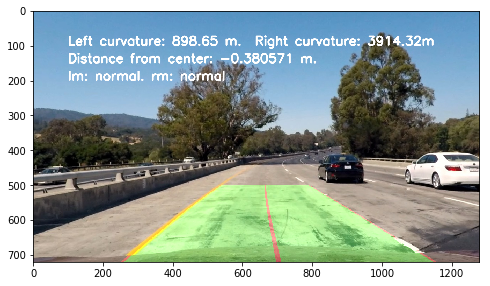

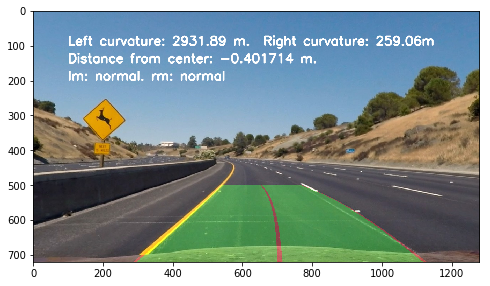

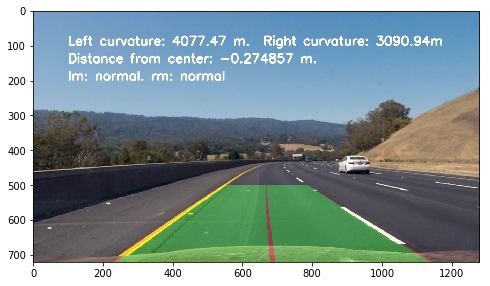

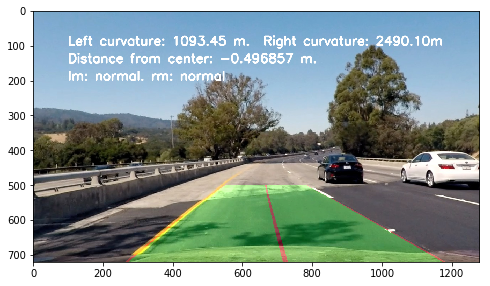

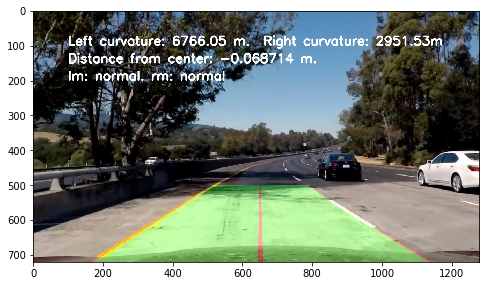

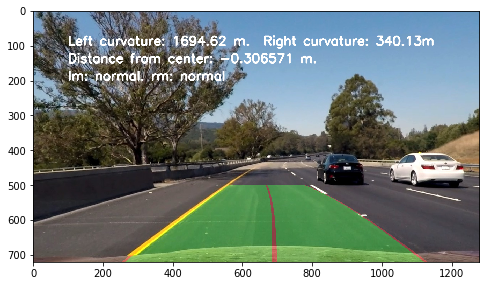

In [24]:
for image_name in glob.glob("test_images/test*.jpg"):
    left_line = Line()
    right_line = Line()
    road_img = mpimg.imread(image_name)
    result = pipeline(road_img)
    figure, axis = plt.subplots(figsize=(8,8))
    
    plt.imshow(pipeline(road_img))
    plt.savefig("output_images/" + image_name, bbox_inches='tight', pad_inches=0)
    plt.figure()


In [8]:
left_line = Line()
right_line = Line()

clip1 = VideoFileClip('project_video.mp4')
video_clip = clip1.fl_image(pipeline)

#NOTE: this function expects color images!!
video_output = 'output_videos/project_video.mp4'
%time video_clip.write_videofile(video_output, audio=False)

Whole [648 648 648 ...,  71  71  71]
[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

Part [700 700 700 ...,   0   0   0]


  0%|          | 3/1261 [00:00<03:36,  5.80it/s]

Part [700 700 700 ...,   0   0   0]
Part [700 700 700 ...,   0   0   0]


  0%|          | 5/1261 [00:00<03:22,  6.19it/s]

Part [700 700 700 ...,   0   0   0]
Part [700 700 700 ...,   0   0   0]


  1%|          | 7/1261 [00:01<03:17,  6.35it/s]

Part [700 700 700 ...,   0   0   0]
Part [699 699 699 ...,   0   0   0]


  1%|          | 9/1261 [00:01<03:11,  6.53it/s]

Part [700 700 700 ...,   0   0   0]
Whole [648 648 648 ...,  71  71  71]


  1%|          | 11/1261 [00:01<03:17,  6.31it/s]

Whole [648 648 648 ...,  71  71  71]
Part [700 700 700 ...,   0   0   0]


  1%|          | 13/1261 [00:02<03:17,  6.31it/s]

Part [699 699 699 ...,   0   0   0]
Part [700 700 700 ...,   0   0   0]


  1%|          | 15/1261 [00:02<03:16,  6.33it/s]

Part [700 700 700 ...,   0   0   0]
Part [700 700 700 ...,   0   0   0]


  1%|▏         | 17/1261 [00:02<03:15,  6.38it/s]

Part [700 700 700 ...,   0   0   0]
Part [700 700 700 ...,   0   0   0]


  2%|▏         | 19/1261 [00:03<03:09,  6.54it/s]

Part [701 701 701 ...,   0   0   0]
Part [700 700 700 ...,   0   0   0]


  2%|▏         | 21/1261 [00:03<03:17,  6.29it/s]

Part [700 700 700 ...,   0   0   0]
Part [700 700 700 ...,   0   0   0]


  2%|▏         | 23/1261 [00:03<03:20,  6.19it/s]

Whole [648 648 648 ...,  71  71  71]
Part [699 699 699 ...,   0   0   0]


  2%|▏         | 25/1261 [00:03<03:18,  6.24it/s]

Part [700 700 700 ...,   0   0   0]
Part [701 701 701 ...,   0   0   0]


  2%|▏         | 26/1261 [00:04<03:15,  6.32it/s]

Part [700 700 700 ...,   0   0   0]


KeyboardInterrupt: 

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</videot
""".format(video_output))

In [9]:
left_line = Line()
right_line = Line()
challenge_file = VideoFileClip('challenge_video.mp4')
challenge_clip = challenge_file.fl_image(pipeline)
#NOTE: this function expects color images!!

video_output = 'output_videos/challenge_video.mp4'
%time challenge_clip.write_videofile(video_output, audio=False)

Whole [648 648 648 ..., 137 137 137]
[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4



  0%|          | 0/485 [00:00<?, ?it/s]

Part [710 710 710 ..., 100 100 100]



  1%|          | 3/485 [00:00<01:22,  5.84it/s]

Part [710 710 710 ..., 164 164 164]
Part [710 710 710 ..., 189 189 189]



  1%|          | 5/485 [00:00<01:18,  6.10it/s]

Part [709 709 709 ..., 262 262 262]
Part [710 710 710 ..., 268 268 268]



  1%|▏         | 7/485 [00:01<01:15,  6.33it/s]

Part [708 708 708 ..., 281 281 281]
Part [710 710 710 ..., 241 241 241]



  2%|▏         | 8/485 [00:01<01:16,  6.26it/s]

Part [709 709 709 ..., 281 281 281]
Part [710 710 710 ..., 293 293 293]



  2%|▏         | 11/485 [00:01<01:16,  6.17it/s]

Part [710 710 710 ..., 317 317 317]
Part [708 708 708 ..., 328 328 328]



  2%|▏         | 12/485 [00:01<01:18,  6.01it/s]

Part [708 708 708 ..., 299 299 299]
Part [708 708 708 ..., 322 322 322]



  3%|▎         | 15/485 [00:02<01:15,  6.24it/s]

Part [710 710 710 ..., 364 364 364]
Part [710 710 710 ..., 383 383 383]



  4%|▎         | 17/485 [00:02<01:13,  6.38it/s]

Part [710 710 710 ..., 268 268 268]
Part [710 710 710 ..., 299 299 299]



  4%|▍         | 19/485 [00:03<01:12,  6.44it/s]

Part [710 710 710 ..., 369 369 369]
Part [710 710 710 ..., 317 317 317]



  4%|▍         | 21/485 [00:03<01:11,  6.48it/s]

Part [710 710 710 ..., 333 333 333]
Part [710 710 710 ..., 322 322 322]



  5%|▍         | 23/485 [00:03<01:11,  6.45it/s]

Part [710 710 710 ..., 333 333 333]
Part [710 710 710 ..., 333 333 333]



  5%|▌         | 25/485 [00:04<01:10,  6.50it/s]

Part [710 710 710 ..., 333 333 333]
Part [710 710 710 ..., 339 339 339]



  6%|▌         | 27/485 [00:04<01:10,  6.51it/s]

Part [710 710 710 ..., 255 255 255]
Part [709 709 709 ..., 281 281 281]



  6%|▌         | 29/485 [00:04<01:09,  6.54it/s]

Part [710 710 710 ..., 317 317 317]
Part [709 709 709 ..., 344 344 344]



  6%|▋         | 31/485 [00:04<01:09,  6.50it/s]

Part [709 709 709 ..., 364 364 364]
Part [710 710 710 ..., 281 281 281]



  7%|▋         | 33/485 [00:05<01:09,  6.49it/s]

Part [710 710 710 ..., 344 344 344]
Part [710 710 710 ..., 344 344 344]



  7%|▋         | 35/485 [00:05<01:07,  6.66it/s]

Part [710 710 710 ..., 333 333 333]
Whole [648 648 648 ..., 431 431 431]



  8%|▊         | 37/485 [00:05<01:06,  6.74it/s]

Whole [648 648 648 ..., 431 431 431]
Part [710 710 710 ..., 354 354 354]



  8%|▊         | 39/485 [00:06<01:05,  6.78it/s]

Whole [648 648 648 ..., 431 431 431]
Whole [648 648 648 ..., 287 287 287]



  8%|▊         | 41/485 [00:06<01:05,  6.77it/s]

Whole [648 648 648 ..., 431 431 431]
Whole [648 648 648 ..., 359 359 359]



  9%|▉         | 43/485 [00:06<01:06,  6.62it/s]

Part [709 709 709 ..., 311 311 311]
Whole [648 648 648 ..., 348 348 348]



  9%|▉         | 45/485 [00:07<01:06,  6.63it/s]

Part [710 710 710 ..., 311 311 311]
Whole [648 648 648 ..., 431 431 431]



 10%|▉         | 47/485 [00:07<01:06,  6.60it/s]

Part [710 710 710 ..., 364 364 364]
Whole [648 648 648 ..., 431 431 431]



 10%|█         | 49/485 [00:07<01:06,  6.59it/s]

Whole [648 648 648 ..., 431 431 431]
Part [710 710 710 ..., 452 452 452]



 11%|█         | 51/485 [00:07<01:05,  6.63it/s]

Whole [648 648 648 ..., 503 503 503]
Whole [648 648 648 ..., 359 359 359]



 11%|█         | 53/485 [00:08<01:05,  6.63it/s]

Part [710 710 710 ..., 374 374 374]
Whole [648 648 648 ..., 431 431 431]



 11%|█▏        | 55/485 [00:08<01:04,  6.68it/s]

Whole [648 648 648 ..., 431 431 431]
Part [710 710 710 ..., 409 409 409]



 12%|█▏        | 57/485 [00:08<01:04,  6.67it/s]

Part [710 710 710 ..., 444 444 444]
Part [711 711 710 ..., 472 472 472]



 12%|█▏        | 59/485 [00:09<01:03,  6.70it/s]

Part [711 711 711 ..., 488 488 488]
Part [711 711 711 ..., 528 528 528]



 13%|█▎        | 61/485 [00:09<01:03,  6.67it/s]

Part [710 710 710 ..., 512 512 512]
Part [711 711 711 ..., 413 413 413]



 13%|█▎        | 63/485 [00:09<01:03,  6.69it/s]

Whole [648 648 648 ..., 575 575 575]
Whole [648 648 648 ..., 566 566 566]



 13%|█▎        | 65/485 [00:10<01:03,  6.59it/s]

Whole [648 648 648 ..., 143 143 143]
Whole [648 648 649 ..., 137 137 137]



 14%|█▍        | 67/485 [00:10<01:03,  6.62it/s]

Whole [648 648 648 648 648 648 648 649 649 649 649 649 649 649 649 650 650 650
 650 650 650 650 650 650 650 651 651 651 651 651 651 651 651 651 651 652
 652 652 652 652 652 652 652 652 652 652 652 653 653 653 653 653 653 653
 653 653 653 653 654 654 654 654 654 654 654 654 654 654 654 655 655 655
 655 655 655 655 655 655 655 656 656 656 656 656 656 656 656 656 656 656
 657 657 657 657 657 657 657 657 657 657 657 658 658 658 658 658 658 658
 658 658 658 658 659 659 659 659 659 659 659 659 659 659 660 660 660 660
 660 660 660 660 660 660 661 661 661 661 661 661 661 661 661 661 662 662
 662 662 662 662 662 662 663 663 663 663 663 663 666 666 666 666 666 666
 666 666 667 667 667 667 667 667 667 667 667 667 668 668 668 668 668 668
 668 668 668 668 669 669 669 669 669 669 669 669 669 670 670 670 670 670
 670 670 670 670 671 671 671 671 671 671 671 671 671 671 671 672 672 672
 672 672 672 672 672 672 672 672 673 673 673 673 673 673 673 673 674 674
 674 674 674 674 674 674 674 675 675 675 675 


 14%|█▍        | 69/485 [00:10<01:02,  6.66it/s]

Whole [651 651 651 ..., 503 503 503]
Whole [648 648 648 ..., 180 180 180]



 15%|█▍        | 71/485 [00:10<01:02,  6.68it/s]

Whole [648 648 648 ..., 143 143 143]
Whole [648 648 648 ..., 428 428 428]



 15%|█▌        | 73/485 [00:11<01:02,  6.64it/s]

Whole [648 648 648 ..., 431 431 431]
Whole [648 648 648 ..., 204 204 204]



 15%|█▌        | 75/485 [00:11<01:01,  6.69it/s]

Whole [648 648 648 ..., 503 503 503]
Whole [648 648 648 ..., 188 188 188]



 16%|█▌        | 77/485 [00:11<01:00,  6.70it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  57  57  57]



 16%|█▋        | 79/485 [00:12<01:00,  6.66it/s]

Whole [648 648 648 ...,  71  71  71]
Right lane:  expected non-empty vector for x
Whole [648 648 648 ...,  71  71  71]



 17%|█▋        | 81/485 [00:12<01:00,  6.66it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]



 17%|█▋        | 83/485 [00:12<01:00,  6.62it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [685 685 685 ...,  35  35  35]



 18%|█▊        | 85/485 [00:13<01:00,  6.65it/s]

Part [686 686 685 ..., 156 156 156]
Whole [576 576 576 ...,  71  71  71]



 18%|█▊        | 87/485 [00:13<01:00,  6.62it/s]

Whole [651 651 651 ...,  35  35  35]
Whole [459 459 459 459 459 459 459 459 460 460 460 460 460 460 460 460 460 461
 461 461 461 461 461 461 461 461 461 462 462 462 462 462 462 462 462 462
 462 462 462 462 463 463 463 463 463 463 463 463 463 463 463 463 463 464
 464 464 464 464 464 464 464 464 464 464 464 464 464 465 465 465 465 465
 465 465 465 465 465 465 465 465 466 466 466 466 466 466 466 466 466 466
 466 466 466 467 467 467 467 467 467 467 467 467 467 467 467 467 468 468
 468 468 468 468 468 468 468 468 468 468 468 468 469 469 469 469 469 469
 469 469 469 469 469 469 469 470 470 470 470 470 470 470 470 470 470 470
 470 470 471 471 471 471 471 471 471 471 471 471 471 471 471 471 472 472
 472 472 472 472 472 473 473 473 473 473 473 473 474 474 474 474 474 474
 475 475 475 475 475 475 475 164 164 164 165 165 165 166 166 166 166 167
 167 167 167 168 168 168 168 169 169 169 169 169 170 170 170 170 170 171
 171 171 171 171 171 172 172 172 172 172 172 173 173 173 173 173 173 173
 174 174


 18%|█▊        | 89/485 [00:13<00:59,  6.67it/s]

Whole [650 650 650 ...,  71  71  71]
Whole [697 697 697 ...,  71  71  71]



 19%|█▉        | 91/485 [00:13<00:59,  6.62it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]



 19%|█▉        | 93/485 [00:14<00:58,  6.68it/s]

Whole [686 686 687 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]



 20%|█▉        | 95/485 [00:14<00:58,  6.67it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [664 664 665 ...,  71  71  71]



 20%|██        | 97/485 [00:14<00:58,  6.66it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]



 20%|██        | 99/485 [00:15<00:57,  6.73it/s]

Whole [662 662 662 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]



 21%|██        | 101/485 [00:15<00:57,  6.71it/s]

Whole [648 648 648 ...,  68  68  68]
Whole [658 658 658 ...,  71  71  71]



 21%|██        | 103/485 [00:15<00:57,  6.61it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]



 22%|██▏       | 105/485 [00:16<00:57,  6.58it/s]

Whole [648 648 648 ...,  57  57  57]
Whole [648 648 648 ...,  35  35  35]



 22%|██▏       | 107/485 [00:16<00:58,  6.52it/s]

Whole [648 648 648 ...,  11  11  11]
Right lane:  expected non-empty vector for x
Whole [648 648 648 ...,  57  67  68]



 22%|██▏       | 109/485 [00:16<00:57,  6.49it/s]

Whole [696 696 696 ...,  68  68  68]
Whole [576 576 576 ...,  70  71  71]



 23%|██▎       | 111/485 [00:16<00:56,  6.57it/s]

Whole [648 648 648 ..., 254 254 254]
Whole [648 648 648 ...,  78  70  71]



 23%|██▎       | 113/485 [00:17<00:56,  6.56it/s]

Part [707 707 707 ..., 328 328 328]
Part [708 708 708 ..., 275 275 275]



 24%|██▎       | 115/485 [00:17<00:55,  6.62it/s]

Part [708 708 707 ..., 197 197 197]
Part [708 708 708 ..., 293 293 293]



 24%|██▍       | 117/485 [00:17<00:55,  6.66it/s]

Part [708 708 708 ..., 197 197 197]
Part [707 707 707 ..., 129 129 129]



 25%|██▍       | 119/485 [00:18<00:54,  6.71it/s]

Part [708 708 708 ...,  69  69  69]
Part [708 708 708 ..., 129 129 129]



 25%|██▍       | 121/485 [00:18<00:55,  6.61it/s]

Part [708 708 708 ..., 173 173 173]
Whole [648 648 648 ..., 143 143 143]



 25%|██▌       | 123/485 [00:18<00:53,  6.72it/s]

Part [709 709 709 ..., 262 262 262]
Part [709 709 709 ..., 305 305 305]



 26%|██▌       | 125/485 [00:19<00:54,  6.64it/s]

Part [709 709 709 ..., 349 349 349]
Part [709 709 709 ..., 396 396 396]



 26%|██▌       | 127/485 [00:19<00:53,  6.73it/s]

Part [709 709 709 ..., 444 444 444]
Part [709 709 709 ..., 491 491 491]



 27%|██▋       | 129/485 [00:19<00:52,  6.84it/s]

Part [709 709 709 ..., 539 539 539]
Part [709 709 709 ..., 586 586 586]



 27%|██▋       | 131/485 [00:19<00:51,  6.82it/s]

Part [710 710 710 ..., 636 636 636]
Whole [687 687 688 688 688 688 688 688 689 689 689 689 689 689 689 689 689 689
 689 690 690 690 690 690 690 690 690 690 690 690 690 690 690 690 691 691
 691 691 691 691 691 691 691 691 691 691 691 691 691 691 691 691 691 691
 691 691 691 691 692 692 692 692 692 692 692 692 692 692 692 692 692 692
 692 692 692 692 692 692 692 692 692 692 692 692 693 693 693 693 693 693
 693 693 693 693 693 693 693 693 693 693 693 693 693 693 693 693 693 693
 693 693 694 694 694 694 694 694 694 694 694 694 694 694 694 694 694 694
 694 694 694 694 694 694 694 694 694 694 694 694 694 694 694 694 694 695
 695 695 695 695 695 695 695 695 695 695 695 695 695 695 695 695 695 695
 695 695 695 695 695 695 695 695 695 695 695 695 695 695 695 695 696 696
 696 696 696 696 696 696 696 696 696 696 696 696 696 696 696 696 696 696
 696 696 696 696 696 696 696 696 696 696 696 696 696 696 696 697 697 697
 697 697 697 697 697 697 697 697 697 697 697 697 697 697 697 697 697 697
 697 697 


 27%|██▋       | 133/485 [00:20<00:50,  6.91it/s]

Whole [648 648 648 648 601 601 601 602 602 602 603 603 603 603 603 604 604 604
 604 605 605 605 605 605 605 605 606 606 606 607 607 607 608 608 608 609
 609 609 610 610 610 611 611 611 612 612 612 612 613 613 613 613 613 614
 614 614 614 614 620 620 620 621 621 621 622 622 622 623 623 623 625 625
 625 626 626 626 626 627 627 627 627 627 628 628 628 628 629 629 629 630
 630 630 630 631 631 631 631 631 632 632 632 632 632 632 633 633 633 633
 633 634 634 634 634 636 636 636 637 637 637 638 638 638 638 639 639 639
 640 640 640 645 645 645 645 646 646 646 646 646 647 647 647 647 647 647]
Whole [664 664 664 664 664 665 665 665 665 666 666 666 666 673 673 673 673 673
 673 674 674 674 674 674 675 675 676 676 676 678 678 678 678 678 678 678
 679 679 679 679 679 679 679 680 680 680 680 680 680 680 680 680 680 680
 680 681 681 681 681 681 681 681 681 681 681 682 682 682 682 682 682 682
 682 682 682 683 683 683 683 683 683 683 683 683 683 683 683 684 684 684
 684 684 684 684 684 684 684 684 684 6


 28%|██▊       | 135/485 [00:20<00:50,  6.89it/s]

Whole [710 710]
Right lane:  expected non-empty vector for x
Whole []
Left lane:  expected non-empty vector for x
Right lane:  expected non-empty vector for x



 28%|██▊       | 137/485 [00:20<00:49,  6.96it/s]

Whole []
Left lane:  expected non-empty vector for x
Right lane:  expected non-empty vector for x
Whole []
Left lane:  expected non-empty vector for x
Right lane:  expected non-empty vector for x



 29%|██▊       | 139/485 [00:21<00:49,  6.93it/s]

Whole []
Left lane:  expected non-empty vector for x
Right lane:  expected non-empty vector for x
Whole []
Left lane:  expected non-empty vector for x
Right lane:  expected non-empty vector for x



 29%|██▉       | 141/485 [00:21<00:49,  6.92it/s]

Whole []
Left lane:  expected non-empty vector for x
Right lane:  expected non-empty vector for x
Whole []
Left lane:  expected non-empty vector for x
Right lane:  expected non-empty vector for x



 29%|██▉       | 143/485 [00:21<00:50,  6.77it/s]

Whole []
Left lane:  expected non-empty vector for x
Right lane:  expected non-empty vector for x
Whole []
Left lane:  expected non-empty vector for x
Right lane:  expected non-empty vector for x



 30%|██▉       | 145/485 [00:21<00:50,  6.70it/s]

Whole []
Left lane:  expected non-empty vector for x
Right lane:  expected non-empty vector for x
Whole [624 624 624 625 625 625 626 626 626   0   0   0   1   1   1   1   2   2
   2   2   3   3   3   3   4   4   4   4   4   5   5   5   5   5   6   6
   6   6   6   7   7   7   7   7   7   8   8   8   8   8   8   9   9   9
   9   9   9   9  10  10  10  10  10  10  10  11  11  11  11  11  11  11
  16  17  18  19  19  20  20  21  21  21  22  22  22  23  23  23]



 30%|███       | 147/485 [00:22<00:50,  6.65it/s]

Whole []
Left lane:  expected non-empty vector for x
Right lane:  expected non-empty vector for x
Whole []
Left lane:  expected non-empty vector for x



 31%|███       | 149/485 [00:22<00:50,  6.70it/s]

Whole []
Left lane:  expected non-empty vector for x
Whole []
Left lane:  expected non-empty vector for x



 31%|███       | 151/485 [00:22<00:50,  6.58it/s]

Whole []
Left lane:  expected non-empty vector for x
Whole [711 711 712 712 712]



 32%|███▏      | 153/485 [00:23<00:50,  6.62it/s]

Whole [360 360 360 ...,  71  71  71]
Whole [432 432 432 ...,  71  71  71]



 32%|███▏      | 155/485 [00:23<00:51,  6.46it/s]

Whole [432 432 432 ...,  68  68  68]
Whole [504 504 504 ...,  71  71  71]



 32%|███▏      | 157/485 [00:23<00:50,  6.55it/s]

Whole [576 576 576 ..., 143 143 143]
Part [626 626 626 ...,  69  69  69]



 33%|███▎      | 159/485 [00:24<00:50,  6.46it/s]

Whole [648 648 648 ..., 143 143 143]
Whole [648 648 648 ...,  71  71  71]



 33%|███▎      | 161/485 [00:24<00:50,  6.46it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]
Right lane:  expected non-empty vector for x



 34%|███▎      | 163/485 [00:24<00:50,  6.40it/s]

Whole [648 648 648 ..., 143 143 143]
Whole [648 648 648 ..., 143 143 143]



 34%|███▍      | 165/485 [00:25<00:49,  6.45it/s]

Whole [648 648 648 ..., 215 215 215]
Whole [648 648 648 ..., 143 143 143]



 34%|███▍      | 167/485 [00:25<00:49,  6.46it/s]

Whole [648 648 648 ...,  71  71  71]
Part [710 710 710 ..., 110 110 110]



 35%|███▍      | 169/485 [00:25<00:48,  6.51it/s]

Part [710 710 710 ..., 126 126 125]
Part [710 710 710 ..., 147 147 147]



 35%|███▌      | 171/485 [00:25<00:48,  6.53it/s]

Part [710 710 710 ..., 147 147 147]
Part [710 710 710 ..., 147 147 147]



 36%|███▌      | 173/485 [00:26<00:47,  6.53it/s]

Part [709 709 709 ..., 147 147 147]
Whole [648 648 648 ..., 215 215 215]



 36%|███▌      | 175/485 [00:26<00:47,  6.52it/s]

Whole [648 648 648 ..., 215 215 215]
Whole [648 648 648 ..., 215 215 215]
Right lane:  expected non-empty vector for x



 36%|███▋      | 177/485 [00:26<00:47,  6.45it/s]

Whole [648 648 648 ..., 143 143 143]
Right lane:  expected non-empty vector for x
Whole [648 648 648 ..., 215 215 215]



 37%|███▋      | 179/485 [00:27<00:46,  6.52it/s]

Whole [648 648 648 ..., 215 215 215]
Whole [648 648 648 ..., 215 215 215]



 37%|███▋      | 181/485 [00:27<00:47,  6.44it/s]

Part [710 710 710 ..., 110 110 110]
Part [710 710 710 ..., 129 129 129]



 38%|███▊      | 183/485 [00:27<00:46,  6.44it/s]

Part [710 710 710 ..., 181 181 181]
Part [710 710 710 ..., 227 227 227]



 38%|███▊      | 185/485 [00:28<00:46,  6.46it/s]

Part [710 710 710 ..., 147 147 147]
Part [710 710 710 ..., 147 147 147]



 39%|███▊      | 187/485 [00:28<00:46,  6.44it/s]

Part [710 710 710 ..., 197 197 197]
Whole [648 648 648 ..., 287 287 287]



 39%|███▉      | 189/485 [00:28<00:46,  6.38it/s]

Whole [648 648 648 ..., 287 287 287]
Whole [648 648 648 ..., 287 287 287]



 39%|███▉      | 191/485 [00:29<00:45,  6.52it/s]

Whole [648 648 648 ..., 211 211 211]
Whole [648 648 648 ..., 287 287 287]



 40%|███▉      | 193/485 [00:29<00:44,  6.57it/s]

Whole [648 648 648 ..., 287 287 287]
Whole [648 648 648 ...,  56  57  57]



 40%|████      | 195/485 [00:29<00:44,  6.55it/s]

Whole [648 648 648 ...,  23  23  23]
Whole [648 648 648 ..., 107 108 108]



 41%|████      | 197/485 [00:29<00:44,  6.52it/s]

Whole [648 648 648 ...,  11  11  11]
Whole [648 648 648 ...,  71  71  71]



 41%|████      | 199/485 [00:30<00:44,  6.47it/s]

Whole [648 648 648 ...,  71  71  71]
Part [709 709 709 ..., 305 305 305]



 41%|████▏     | 201/485 [00:30<00:43,  6.58it/s]

Part [709 709 709 ..., 305 305 305]
Whole [648 648 648 ...,  71  71  71]



 42%|████▏     | 203/485 [00:30<00:43,  6.54it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]



 42%|████▏     | 205/485 [00:31<00:43,  6.50it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  46  46  46]



 43%|████▎     | 207/485 [00:31<00:42,  6.61it/s]

Part [709 709 709 ..., 311 311 311]
Whole [648 648 648 ...,  71  71  71]



 43%|████▎     | 209/485 [00:31<00:41,  6.58it/s]

Part [708 708 708 ..., 255 255 255]
Part [708 708 708 ..., 255 255 255]



 44%|████▎     | 211/485 [00:32<00:41,  6.63it/s]

Part [708 708 708 ..., 299 299 299]
Part [710 710 710 ..., 212 212 212]



 44%|████▍     | 213/485 [00:32<00:40,  6.64it/s]

Part [710 710 710 ..., 241 241 241]
Part [710 710 710 ..., 255 255 255]



 44%|████▍     | 215/485 [00:32<00:40,  6.67it/s]

Whole [648 648 648 ...,  35  35  35]
Whole [648 648 648 ...,  46  46  46]



 45%|████▍     | 217/485 [00:32<00:41,  6.46it/s]

Whole [648 648 648 ...,  71  71  71]
Right lane:  expected non-empty vector for x
Whole [648 648 648 ...,  71  71  71]



 45%|████▌     | 219/485 [00:33<00:40,  6.58it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]



 46%|████▌     | 221/485 [00:33<00:40,  6.50it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ..., 359 359 359]



 46%|████▌     | 223/485 [00:33<00:39,  6.58it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ..., 358 358 358]



 46%|████▋     | 225/485 [00:34<00:39,  6.56it/s]

Whole [648 648 648 ...,  11  11  11]
Whole [648 648 648 ...,  46  46  46]



 47%|████▋     | 227/485 [00:34<00:39,  6.59it/s]

Whole [648 648 648 ...,  46  46  46]
Whole [648 648 648 ..., 143 143 143]



 47%|████▋     | 229/485 [00:34<00:39,  6.54it/s]

Whole [648 648 648 ..., 143 143 143]
Whole [648 648 648 ...,  71  71  71]



 48%|████▊     | 231/485 [00:35<00:38,  6.59it/s]

Whole [648 648 648 ..., 143 143 143]
Whole [648 648 648 ..., 143 143 143]



 48%|████▊     | 233/485 [00:35<00:38,  6.58it/s]

Whole [648 648 648 ..., 108 108 108]
Whole [648 648 648 ..., 188 188 188]



 48%|████▊     | 235/485 [00:35<00:37,  6.61it/s]

Whole [648 648 648 ..., 143 143 143]
Whole [648 648 648 ...,  71  71  71]



 49%|████▉     | 237/485 [00:36<00:37,  6.53it/s]

Whole [648 648 648 ..., 359 359 359]
Whole [654 654 654 ..., 118 118 118]



 49%|████▉     | 239/485 [00:36<00:37,  6.56it/s]

Part [705 705 705 ..., 333 333 333]
Whole [648 648 648 ..., 143 143 143]



 50%|████▉     | 241/485 [00:36<00:37,  6.54it/s]

Whole [648 648 648 ...,  68  68  68]
Whole [648 648 648 ..., 359 359 359]



 50%|█████     | 243/485 [00:36<00:37,  6.48it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  68  68  68]
Right lane:  expected non-empty vector for x



 51%|█████     | 245/485 [00:37<00:36,  6.50it/s]

Whole [648 648 648 ...,  71  71  71]
Right lane:  expected non-empty vector for x
Whole [648 648 648 ..., 143 143 143]
Right lane:  expected non-empty vector for x



 51%|█████     | 247/485 [00:37<00:37,  6.42it/s]

Whole [648 648 648 ...,  46  46  46]
Whole [648 648 648 ...,  71  71  71]



 51%|█████▏    | 249/485 [00:37<00:36,  6.54it/s]

Whole [648 648 648 ..., 143 143 143]
Whole [648 648 648 ...,  71  71  71]



 52%|█████▏    | 251/485 [00:38<00:35,  6.57it/s]

Whole [648 648 648 ...,  46  46  46]
Whole [648 648 648 ...,  68  68  68]



 52%|█████▏    | 253/485 [00:38<00:35,  6.61it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]



 53%|█████▎    | 255/485 [00:38<00:35,  6.51it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]



 53%|█████▎    | 257/485 [00:39<00:34,  6.57it/s]

Whole [648 648 648 ...,  68  68  68]
Whole [648 648 648 ...,  71  71  71]
Right lane:  expected non-empty vector for x



 53%|█████▎    | 259/485 [00:39<00:35,  6.44it/s]

Whole [648 648 648 ...,  68  68  68]
Whole [648 648 648 ...,  71  71  71]



 54%|█████▍    | 261/485 [00:39<00:34,  6.52it/s]

Whole [648 648 648 ...,  11  11  11]
Part [710 710 710 ..., 293 293 293]



 54%|█████▍    | 263/485 [00:40<00:33,  6.53it/s]

Part [710 710 710 ..., 293 293 293]
Part [710 710 710 ..., 317 317 317]



 55%|█████▍    | 265/485 [00:40<00:33,  6.63it/s]

Part [709 709 709 ..., 333 333 333]
Part [708 708 708 ..., 333 333 333]



 55%|█████▌    | 267/485 [00:40<00:32,  6.65it/s]

Part [709 709 709 ..., 374 374 374]
Part [709 709 709 ..., 374 374 374]



 55%|█████▌    | 269/485 [00:40<00:32,  6.66it/s]

Part [710 710 710 ..., 354 354 354]
Part [710 710 710 ..., 333 333 333]



 56%|█████▌    | 271/485 [00:41<00:32,  6.51it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]



 56%|█████▋    | 273/485 [00:41<00:32,  6.58it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  57  57  57]



 57%|█████▋    | 275/485 [00:41<00:32,  6.55it/s]

Whole [648 648 648 ...,  46  46  46]
Whole [648 648 648 ...,  71  71  71]



 57%|█████▋    | 277/485 [00:42<00:31,  6.64it/s]

Part [710 710 710 ..., 317 317 317]
Part [709 709 709 ..., 311 311 311]



 58%|█████▊    | 279/485 [00:42<00:31,  6.59it/s]

Part [709 709 709 ..., 322 322 322]
Part [710 710 710 ..., 333 333 333]



 58%|█████▊    | 281/485 [00:42<00:30,  6.63it/s]

Part [710 710 710 ..., 369 369 369]
Part [709 709 709 ..., 333 333 333]



 58%|█████▊    | 283/485 [00:43<00:30,  6.60it/s]

Part [709 709 709 ..., 374 374 374]
Whole [648 648 648 ...,  68  68  68]



 59%|█████▉    | 285/485 [00:43<00:30,  6.62it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]



 59%|█████▉    | 287/485 [00:43<00:30,  6.57it/s]

Whole [648 648 648 ...,  71  71  71]
Right lane:  expected non-empty vector for x
Whole [648 648 648 ...,  71  71  71]



 60%|█████▉    | 289/485 [00:43<00:30,  6.53it/s]

Whole [648 648 648 ...,  35  35  35]
Whole [648 648 648 ...,  71  71  71]



 60%|██████    | 291/485 [00:44<00:29,  6.52it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  57  57  57]



 60%|██████    | 293/485 [00:44<00:30,  6.39it/s]

Whole [648 648 648 ...,  57  57  57]
Part [710 710 710 ..., 119 119 119]



 61%|██████    | 295/485 [00:44<00:29,  6.42it/s]

Part [708 708 708 ...,   0   0   0]
Whole [648 648 648 ...,  71  71  71]



 61%|██████    | 297/485 [00:45<00:28,  6.56it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]



 62%|██████▏   | 299/485 [00:45<00:28,  6.60it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]



 62%|██████▏   | 301/485 [00:45<00:28,  6.52it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  46  46  46]



 62%|██████▏   | 303/485 [00:46<00:27,  6.53it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]



 63%|██████▎   | 305/485 [00:46<00:27,  6.55it/s]

Part [709 709 709 ..., 344 344 344]
Whole [648 648 648 ..., 118 118 118]



 63%|██████▎   | 307/485 [00:46<00:27,  6.52it/s]

Whole [648 648 648 ...,  68  68  68]
Whole [648 648 648 ...,  71  71  71]



 64%|██████▎   | 309/485 [00:46<00:26,  6.57it/s]

Whole [648 648 648 ...,  71  71  71]
Part [708 708 708 ...,   0   0   0]



 64%|██████▍   | 311/485 [00:47<00:26,  6.46it/s]

Part [709 709 708 ...,   0   0   0]
Whole [648 648 648 ...,  71  71  71]



 65%|██████▍   | 313/485 [00:47<00:26,  6.41it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]



 65%|██████▍   | 315/485 [00:47<00:26,  6.39it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]



 65%|██████▌   | 317/485 [00:48<00:26,  6.44it/s]

Whole [648 648 648 ...,  57  57  57]
Whole [648 648 648 ...,  71  71  71]



 66%|██████▌   | 319/485 [00:48<00:25,  6.43it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]



 66%|██████▌   | 321/485 [00:48<00:25,  6.44it/s]

Part [710 710 710 ..., 299 299 299]
Whole [648 648 648 ...,  46  46  46]



 67%|██████▋   | 323/485 [00:49<00:24,  6.56it/s]

Part [710 710 710 ..., 328 328 328]
Whole [648 648 648 ...,  71  71  71]



 67%|██████▋   | 325/485 [00:49<00:24,  6.53it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]



 67%|██████▋   | 327/485 [00:49<00:24,  6.56it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]



 68%|██████▊   | 329/485 [00:50<00:24,  6.45it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ..., 143 143 143]



 68%|██████▊   | 331/485 [00:50<00:23,  6.44it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]



 69%|██████▊   | 333/485 [00:50<00:23,  6.48it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]



 69%|██████▉   | 335/485 [00:51<00:22,  6.54it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]



 69%|██████▉   | 337/485 [00:51<00:22,  6.54it/s]

Part [709 709 709 ...,   1   1   1]
Part [709 709 709 ...,   0   0   0]



 70%|██████▉   | 339/485 [00:51<00:22,  6.61it/s]

Whole [648 648 648 ..., 143 143 143]
Whole [648 648 648 ..., 204 204 204]



 70%|███████   | 341/485 [00:51<00:22,  6.47it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]



 71%|███████   | 343/485 [00:52<00:21,  6.62it/s]

Whole [648 648 648 ...,  71  71  71]
Part [710 710 710 ...,   0   0   0]



 71%|███████   | 345/485 [00:52<00:21,  6.61it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]



 72%|███████▏  | 347/485 [00:52<00:21,  6.54it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]



 72%|███████▏  | 349/485 [00:53<00:20,  6.49it/s]

Whole [648 648 648 ...,  71  71  71]
Part [710 710 710 ..., 322 322 322]



 72%|███████▏  | 351/485 [00:53<00:20,  6.58it/s]

Part [710 710 710 ..., 268 268 268]
Part [710 710 710 ..., 268 268 268]



 73%|███████▎  | 353/485 [00:53<00:20,  6.45it/s]

Whole [648 648 648 ...,  71  71  71]
Whole [648 648 648 ...,  71  71  71]



 73%|███████▎  | 355/485 [00:54<00:19,  6.53it/s]

Whole [648 648 648 ...,  71  71  71]
Right lane:  expected non-empty vector for x
Whole [648 648 648 ...,  71  71  71]
Right lane:  expected non-empty vector for x



 74%|███████▎  | 357/485 [00:54<00:19,  6.53it/s]

Whole [648 648 648 ...,  68  68  68]
Right lane:  expected non-empty vector for x
Whole [648 648 648 ...,  71  71  71]



 74%|███████▍  | 359/485 [00:54<00:19,  6.59it/s]

Part [710 710 710 ..., 293 293 293]
Whole [648 648 648 ...,  71  71  71]



 74%|███████▍  | 361/485 [00:54<00:18,  6.59it/s]

Part [710 710 710 ..., 392 392 392]
Part [710 710 710 ..., 212 212 212]



 75%|███████▍  | 363/485 [00:55<00:18,  6.65it/s]

Part [710 710 710 ..., 227 227 227]
Part [710 710 710 ..., 401 401 401]



 75%|███████▌  | 365/485 [00:55<00:18,  6.53it/s]

Part [710 710 710 ..., 293 293 293]
Part [708 708 708 ..., 281 281 281]



 76%|███████▌  | 367/485 [00:55<00:18,  6.28it/s]

Whole [648 648 648 ...,  71  71  71]
Part [710 710 710 ..., 322 322 322]



 76%|███████▌  | 369/485 [00:56<00:18,  6.39it/s]

Part [710 710 710 ..., 333 333 333]
Part [710 710 710 ..., 311 311 311]



 76%|███████▋  | 371/485 [00:56<00:17,  6.48it/s]

Part [710 710 710 ..., 322 322 322]
Part [709 709 709 ..., 322 322 322]



 77%|███████▋  | 373/485 [00:56<00:17,  6.46it/s]

Part [709 709 709 ..., 287 287 287]
Part [709 709 709 ..., 317 317 317]



 77%|███████▋  | 375/485 [00:57<00:16,  6.57it/s]

Part [710 710 710 ..., 311 311 311]
Part [710 710 710 ..., 317 317 317]



 78%|███████▊  | 377/485 [00:57<00:16,  6.50it/s]

Whole [648 648 648 ...,  68  68  68]
Whole [648 648 648 ...,  66  67  68]



 78%|███████▊  | 379/485 [00:57<00:16,  6.41it/s]

Whole [648 648 648 ...,  71  71  71]
Part [710 710 710 ..., 392 392 392]



 79%|███████▊  | 381/485 [00:58<00:16,  6.38it/s]

Part [710 710 710 ..., 392 392 392]
Part [710 710 710 ..., 401 401 401]



 79%|███████▉  | 383/485 [00:58<00:15,  6.51it/s]

Whole [648 648 648 ...,  46  46  46]
Right lane:  expected non-empty vector for x
Whole [648 648 648 ...,  35  56  57]
Right lane:  expected non-empty vector for x



 79%|███████▉  | 385/485 [00:58<00:15,  6.56it/s]

Whole [648 648 648 ...,  23  23  23]
Part [711 711 711 ..., 401 401 401]



 80%|███████▉  | 387/485 [00:58<00:14,  6.59it/s]

Part [711 711 711 ..., 409 409 409]
Part [711 711 711 ..., 354 354 354]



 80%|████████  | 389/485 [00:59<00:14,  6.60it/s]

Part [711 711 711 ..., 268 268 268]
Part [711 711 711 ..., 293 293 293]



 81%|████████  | 391/485 [00:59<00:14,  6.63it/s]

Part [710 710 710 ..., 299 299 299]
Part [710 710 710 ..., 328 328 328]



 81%|████████  | 393/485 [00:59<00:13,  6.60it/s]

Part [713 713 713 ..., 344 344 344]
Part [713 713 713 ..., 364 364 364]



 81%|████████▏ | 395/485 [01:00<00:13,  6.60it/s]

Whole [648 648 648 ..., 431 431 431]
Whole [648 648 648 ..., 431 431 431]



 82%|████████▏ | 397/485 [01:00<00:13,  6.59it/s]

Whole [648 648 648 ..., 359 359 359]
Whole [648 648 648 ..., 359 359 359]



 82%|████████▏ | 399/485 [01:00<00:13,  6.56it/s]

Whole [648 648 648 ..., 321 321 321]
Whole [648 648 648 ..., 274 274 274]



 83%|████████▎ | 401/485 [01:01<00:12,  6.48it/s]

Whole [648 648 648 ..., 261 261 261]
Whole [648 648 648 ..., 280 280 280]



 83%|████████▎ | 403/485 [01:01<00:12,  6.53it/s]

Whole [648 648 648 ..., 359 359 359]
Whole [648 648 648 ..., 287 287 287]



 84%|████████▎ | 405/485 [01:01<00:12,  6.39it/s]

Whole [650 650 650 ..., 287 287 287]
Whole [648 648 648 ..., 359 359 359]



 84%|████████▍ | 407/485 [01:02<00:12,  6.48it/s]

Part [711 711 711 ..., 364 364 364]
Part [711 711 711 ..., 354 354 354]



 84%|████████▍ | 409/485 [01:02<00:11,  6.51it/s]

Whole [648 648 648 ..., 424 424 424]
Whole [648 648 648 ..., 431 431 431]



 85%|████████▍ | 411/485 [01:02<00:11,  6.42it/s]

Whole [648 648 648 ..., 431 431 431]
Right lane:  expected non-empty vector for x
Whole [648 648 648 ..., 359 359 359]



 85%|████████▌ | 413/485 [01:02<00:11,  6.46it/s]

Part [710 710 710 ..., 344 344 344]
Part [710 710 710 ..., 333 333 333]



 86%|████████▌ | 415/485 [01:03<00:10,  6.58it/s]

Part [710 710 710 ..., 354 354 354]
Part [710 710 710 ..., 374 374 374]



 86%|████████▌ | 417/485 [01:03<00:10,  6.56it/s]

Part [710 710 710 ..., 344 344 344]
Whole [648 648 648 ..., 420 420 420]



 86%|████████▋ | 419/485 [01:03<00:09,  6.62it/s]

Part [709 709 709 ..., 374 374 374]
Part [709 709 709 ..., 354 354 354]



 87%|████████▋ | 421/485 [01:04<00:09,  6.57it/s]

Part [710 710 710 ..., 354 354 354]
Part [710 710 710 ..., 322 322 322]



 87%|████████▋ | 423/485 [01:04<00:09,  6.66it/s]

Part [710 710 710 ..., 364 364 364]
Part [709 709 709 ..., 364 364 364]



 88%|████████▊ | 425/485 [01:04<00:09,  6.66it/s]

Part [709 709 709 ..., 333 333 333]
Part [709 709 709 ..., 374 374 374]



 88%|████████▊ | 427/485 [01:05<00:08,  6.66it/s]

Part [709 709 709 ..., 227 227 227]
Part [710 710 710 ..., 322 322 322]



 88%|████████▊ | 429/485 [01:05<00:08,  6.57it/s]

Part [710 710 710 ..., 311 311 311]
Part [710 710 710 ..., 339 339 339]



 89%|████████▉ | 431/485 [01:05<00:08,  6.53it/s]

Part [710 710 710 ..., 364 364 364]
Part [710 710 710 ..., 374 374 374]



 89%|████████▉ | 433/485 [01:05<00:07,  6.52it/s]

Part [709 709 709 ..., 354 354 354]
Part [709 709 709 ..., 364 364 364]



 90%|████████▉ | 435/485 [01:06<00:07,  6.59it/s]

Part [710 710 710 ..., 354 354 354]
Part [710 710 710 ..., 392 392 392]



 90%|█████████ | 437/485 [01:06<00:07,  6.42it/s]

Whole [648 648 648 ..., 310 310 310]
Whole [648 648 648 ..., 359 359 359]



 91%|█████████ | 439/485 [01:06<00:07,  6.45it/s]

Whole [648 648 648 ..., 359 359 359]
Whole [648 648 648 ..., 359 359 359]



 91%|█████████ | 441/485 [01:07<00:06,  6.50it/s]

Whole [648 648 648 ..., 359 359 359]
Whole [648 648 648 ..., 286 286 286]



 91%|█████████▏| 443/485 [01:07<00:06,  6.59it/s]

Whole [659 659 659 ..., 274 274 274]
Whole [648 648 648 ..., 254 254 254]



 92%|█████████▏| 445/485 [01:07<00:06,  6.52it/s]

Whole [648 648 648 ..., 359 359 359]
Whole [648 648 648 ..., 359 359 359]



 92%|█████████▏| 447/485 [01:08<00:05,  6.60it/s]

Whole [648 648 648 ..., 359 359 359]
Whole [648 648 648 ..., 359 359 359]



 93%|█████████▎| 449/485 [01:08<00:05,  6.57it/s]

Part [709 709 709 ..., 383 383 383]
Whole [648 648 648 ..., 431 431 431]



 93%|█████████▎| 451/485 [01:08<00:05,  6.49it/s]

Part [709 709 709 ..., 311 311 311]
Part [709 709 709 ..., 212 212 212]



 93%|█████████▎| 453/485 [01:09<00:04,  6.53it/s]

Part [709 709 709 ..., 227 227 227]
Part [710 710 710 ..., 227 227 227]



 94%|█████████▍| 455/485 [01:09<00:04,  6.62it/s]

Part [710 710 710 ..., 255 255 255]
Part [709 709 709 ..., 268 268 268]



 94%|█████████▍| 457/485 [01:09<00:04,  6.59it/s]

Part [708 708 708 ..., 227 227 227]
Part [708 708 708 ..., 255 255 255]



 95%|█████████▍| 459/485 [01:09<00:03,  6.57it/s]

Part [708 708 708 ..., 275 275 275]
Part [709 709 709 ..., 241 241 241]



 95%|█████████▌| 461/485 [01:10<00:03,  6.61it/s]

Part [709 709 709 ..., 268 268 268]
Part [709 709 709 ..., 275 275 275]



 95%|█████████▌| 463/485 [01:10<00:03,  6.63it/s]

Part [709 709 709 ..., 255 255 255]
Part [709 709 709 ..., 227 227 227]



 96%|█████████▌| 465/485 [01:10<00:03,  6.54it/s]

Part [709 709 709 ..., 241 241 241]
Part [709 709 709 ..., 268 268 268]



 96%|█████████▋| 467/485 [01:11<00:02,  6.59it/s]

Part [708 708 708 ..., 293 293 293]
Part [709 709 709 ..., 328 328 328]



 97%|█████████▋| 469/485 [01:11<00:02,  6.55it/s]

Part [709 709 709 ..., 110 110 110]
Part [709 709 709 ..., 110 110 110]



 97%|█████████▋| 471/485 [01:11<00:02,  6.58it/s]

Part [709 709 709 ..., 147 147 147]
Part [709 709 709 ..., 212 212 212]



 98%|█████████▊| 473/485 [01:12<00:01,  6.48it/s]

Part [709 709 709 ..., 212 212 212]
Part [708 708 708 ..., 147 147 147]



 98%|█████████▊| 475/485 [01:12<00:01,  6.57it/s]

Part [708 708 708 ..., 164 164 164]
Whole [648 648 648 ..., 215 215 215]



 98%|█████████▊| 477/485 [01:12<00:01,  6.59it/s]

Part [708 708 708 ..., 212 212 212]
Part [709 709 709 ..., 241 241 241]



 99%|█████████▉| 479/485 [01:12<00:00,  6.62it/s]

Whole [648 648 648 ..., 287 287 287]
Whole [648 648 648 ..., 359 359 359]



 99%|█████████▉| 481/485 [01:13<00:00,  6.52it/s]

Whole [648 648 648 ..., 359 359 359]
Whole [648 648 648 ..., 287 287 287]



100%|█████████▉| 483/485 [01:13<00:00,  6.60it/s]

Whole [648 648 648 ..., 287 287 287]
Whole [648 648 648 ..., 359 359 359]



100%|██████████| 485/485 [01:13<00:00,  6.57it/s]


Whole [648 648 648 ..., 359 359 359]
Whole [648 648 648 ..., 359 359 359]
[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

CPU times: user 2min 42s, sys: 4.88 s, total: 2min 47s
Wall time: 1min 14s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</videot
""".format(video_output))

In [ ]:
def pipeline_warped(frame):
    global mtx
    global dist

    
    undistorted = aCV.undistort_image(frame, mtx, dist)
    
    thresholded = aCV.threshold_image(undistorted)
    
    width = thresholded.shape[1]
    height = thresholded.shape[0]

    #requires the test image to be nearly horizontally symmetrical
    ref_width = 520
    ref_height = 500
    width_offset = 190
    margin = 50
    minpix = 80
    #transformed: transformed image
    #T_mat: transformation matrix

    source = aCV.transform_source(width, height, width_offset, ref_width, ref_height)
    destination = aCV.transform_destination(width, height, 0.1 * width)
    
    warped, T_mat, inv_mat = aCV.warp(thresholded, source, destination)
    
    left_window = []
    right_window = []
    #warped = thresholded
    if not left_line.detected or not right_line.detected:
        leftx, lefty, rightx, righty, out_img, left_window, right_window = \
        aCV.scan_lane_pixels(warped, nwindows = 10, margin = margin, minpix = minpix)
        print("Whole")
        searchAroundPrev = False
    else:
        leftx, lefty, rightx, righty, out_img = aCV.search_around_poly(warped, left_line.best_fit, 
                                                                       right_line.best_fit, margin = margin)
        lefty = lefty[::-1]
        leftx = leftx[::-1]
        righty = righty[::-1]
        rightx = rightx[::-1]
        print("Part", lefty)
        searchAroundPrev = True
    

    
    left_fit_coeffs, right_fit_coeffs = aCV.fit_polynomial(leftx, lefty, rightx, righty, useWeight=True)
    
#     print("Length: ", len(leftx), len(rightx))
    
#     print("Coeffs:", left_fit_coeffs, right_fit_coeffs)
    
    height = frame.shape[0]
    ploty = np.linspace(0, height-1, height)
    
    left_line.update(left_fit_coeffs, leftx, ploty)
    right_line.update(right_fit_coeffs, rightx, ploty)
    
    #Draw detected lanes
#     if not runNormal:
    warped_lane = aCV.fill_lane(warped, leftx, lefty, rightx, righty, 
                                left_line.bestx, right_line.bestx, ploty, 
                                left_window, right_window, searchAroundPrev)
#     else:
#         warped_lane = aCV.draw_detected_lane_lines(warped, leftx, lefty, rightx, righty, 
#                                                left_line.bestx, right_line.bestx, ploty, margin = margin)
    
    warped = np.uint8(np.dstack((warped, warped, warped)))
    result = cv2.addWeighted(warped, 1, warped_lane, 0.5, 0)
    cv2.putText(result, "L count: {0}. R count {1}.".format(left_line.count, right_line.count), 
                         (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 3,  cv2.LINE_AA)
    
    cv2.putText(result, "lm: {0}. rm: {1}".format(left_line.warning, right_line.warning),
                    (100, 200), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 3,  cv2.LINE_AA)
    
    cv2.putText(result, "lc: {0}. rc: {1}".format(left_line.best_fit, right_line.best_fit),
                    (100, 300), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 3,  cv2.LINE_AA)
    
    cv2.putText(result, "lc: {0}. rc: {1}".format(len(leftx), len(rightx)),
                    (100, 400), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,255,255), 3,  cv2.LINE_AA)
    
    left_line.checkNeedReset()
    right_line.checkNeedReset()
    return result

left_line = Line()
right_line = Line()
challenge_file = VideoFileClip('challenge_video.mp4')
challenge_clip = challenge_file.fl_image(pipeline_warped)
#NOTE: this function expects color images!!

video_output = 'output_videos/challenge_video_warped_withWeight.mp4'
%time challenge_clip.write_videofile(video_output, audio=False)

In [ ]:
# def pipeline_thresholded(frame):
#     global mtx
#     global dist

#     undistorted = aCV.undistort_image(frame, mtx, dist)
    
#     thresholded = aCV.threshold_image(undistorted)
    
#     width = thresholded.shape[1]
#     height = thresholded.shape[0]

#     #requires the test image to be nearly horizontally symmetrical
#     ref_width = 520
#     ref_height = 500
#     width_offset = 190
    
# #     #transformed: transformed image
# #     #T_mat: transformation matrix

#     source = aCV.transform_source(width, height, width_offset, ref_width, ref_height)
#     destination = aCV.transform_destination(width, height, 0.1 * width)
    
    
# #     warped, T_mat, inv_mat = aCV.warp(thresholded, source, destination)
#     #warped = thresholded
    
#     result =  np.uint8(np.dstack((thresholded, thresholded, thresholded)))
#     pts = source.reshape((-1,1,2))
#     cv2.polylines(result,np.int_([pts]),True,(0,255,255))
#     return result
    
# challenge_file = VideoFileClip('challenge_video.mp4')
# challenge_clip = challenge_file.fl_image(pipeline_thresholded)
# #NOTE: this function expects color images!!

# video_output = 'output_videos/challenge_video_thresholded.mp4'
# %time challenge_clip.write_videofile(video_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</videot
""".format(video_output))

In [ ]:
left_line = Line()
right_line = Line()

clip2 = VideoFileClip('harder_challenge_video.mp4')
harder_clip = clip2.fl_image(pipeline)
#NOTE: this function expects color images!!
harder_output = 'output_videos/harder_video.mp4'
%time harder_clip.write_videofile(harder_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</videot
""".format(harder_output))

In [ ]:
print(aCV.transform_source(width, height, width_offset, ref_width, ref_height))